# Tarea 1: procesamiento de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# cargar datos
data00 = pd.read_csv('https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/tarea_01/data/CWRU_48k_DE000.csv')
print('healthy shape {}'.format(data00.shape))
data07 = pd.read_csv('https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/tarea_01/data/CWRU_48k_DE007.csv')
print('07 shape {}'.format(data07.shape))
data14 = pd.read_csv('https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/tarea_01/data/CWRU_48k_DE014.csv')
print('14 shape {}'.format(data14.shape))
data21 = pd.read_csv('https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/tarea_01/data/CWRU_48k_DE021.csv')
print('21 shape {}'.format(data21.shape))

# se concatenan los datos para separar facilmente
data = pd.concat([data00, data07, data14, data21], axis=1)

print(data.shape)
data.head()

healthy shape (288000, 1)
07 shape (288000, 3)
14 shape (288000, 3)
21 shape (288000, 3)
(288000, 10)


,Healthy,IR007,B007,OR007,IR014,B014,OR014,IR021,B021,OR021
0,0.046104,0.032127,-0.041097,0.084719,-0.010016,-0.463543,0.133305,1.121099,-0.061959,0.040064
1,-0.037134,0.078231,-0.046104,0.694860,-0.002921,-0.475852,0.152498,0.783351,-0.037551,0.021701
2,-0.089496,0.161468,-0.028372,1.159769,0.005425,-0.418065,0.166475,0.391571,-0.017941,-0.020867
3,-0.084906,0.250547,0.001252,1.397232,0.017528,-0.313966,0.148534,-0.060498,0.019401,-0.065104
4,-0.038594,0.315426,0.033796,1.413508,0.021284,-0.171482,0.112652,-0.502972,0.049650,-0.111845


In [3]:
def get_time_windows(data, nperwd, nleap):
  """
  -> np.array

  generates a numpy array of time windows, of length nperwd, extracted
  from data.

  :param pd.Series data:
    time series of measurement values.
  :param int nperwd:
    length of samples of each time window.
  :param int nleap:
    length of leap between time windows.

  :returns:
    a numpy array of size (n_windows, nperwd).
  """

  # obtener np.array de la serie de datos
  x = data.values
  n_data = x.shape[0]
  
  # determinar cantidad de ventanas a generar
  n_windows = np.floor( (n_data - nperwd)/nleap ) + 1
  n_windows = int(n_windows)

  # inicializar dataset
  X = np.zeros( (n_windows, nperwd, x.shape[1]) )
  
  # generar time windows
  for i in range(n_windows):
    # obtener index de la ventana
    idx_start, idx_end = i*nleap, i*nleap + nperwd

    # asignar datos a X
    X[i, :, :] = x[idx_start:idx_end,:]
  
  return X


train (207361, 10), validation (51841, 10) and test (28800, 10) shapes
train (1035, 500, 10)
val (257, 500, 10)
test (142, 500, 10)


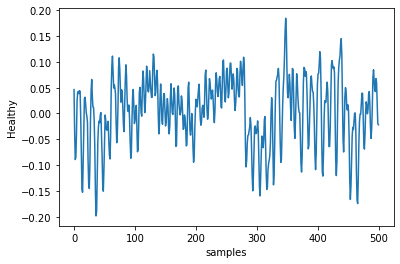

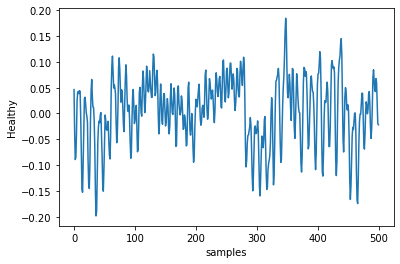

In [4]:
# dividir los datos para evitar el data leak
n_train = int(0.9 * data.shape[0])
train_data = data.loc[:n_train,:]
test_data = data.loc[n_train:,:]

n_train = int(0.8 * train_data.shape[0])
val_data = train_data.loc[n_train:,:]
train_data = train_data.loc[:n_train,:]

print('train {}, validation {} and test {} shapes'.format(train_data.shape,
                                                          val_data.shape,
                                                          test_data.shape))

nperwd = 500
nleap = 200

X_train = get_time_windows(train_data, nperwd, nleap)
print('train {}'.format(X_train.shape))
X_val = get_time_windows(val_data, nperwd, nleap)
print('val {}'.format(X_val.shape))
X_test = get_time_windows(test_data, nperwd, nleap)
print('test {}'.format(X_test.shape))

plt.plot(X_train[0,:,0])
plt.xlabel('samples'), plt.ylabel('Healthy')
plt.show()

plt.plot(train_data.loc[:,'Healthy'][:nperwd])
plt.xlabel('samples'), plt.ylabel('Healthy')
plt.show()


In [5]:
from keras.utils import to_categorical

# generar np.array Y_train con las etiquetas correspondientes
def toCategorical(df):
  Y = []
  for y, c in enumerate(df):
    Y.append([y] * df[c].shape[0])
  Y = np.concatenate(Y)
  return to_categorical(Y, num_classes=10)

def crearDF(X):
  df = {'Healthy':   X[:,:,0],
        'IR07':      X[:,:,1],
        'B07':       X[:,:,2],
        'OR07':      X[:,:,3],
        'IR14':      X[:,:,4],
        'B14':       X[:,:,5],
        'OR14':      X[:,:,6],
        'IR21':      X[:,:,7],
        'B21':       X[:,:,8],
        'OR21':      X[:,:,9]}
  return df


In [6]:
Y_train = toCategorical(crearDF(X_train))
Y_val = toCategorical(crearDF(X_val))
Y_test = toCategorical(crearDF(X_test))

print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)


(10350, 10)
(2570, 10)
(1420, 10)


In [7]:
X_train = np.vstack([X_train[:,:,i] for i in range(10)])
X_val = np.vstack([X_val[:,:,i] for i in range(10)])
X_test = np.vstack([X_test[:,:,i] for i in range(10)])

In [8]:
# guardar raw data cargada con los respectivos labels
np.savez('raw_data.npz',
         X_train=X_train, Y_train=Y_train,
         X_val=X_val, Y_val=Y_val,
         X_test=X_test, Y_test=Y_test)

In [9]:
from scipy.stats import kurtosis
from scipy.stats import skew

def extract_features(x):
  """
  -> np.array

  compute 9 signal features for each sample along the data x:
  - mean, variance.
  - rms, peak, valley, peak2peak.
  - crest factor, kurtosis, skewness.

  :param np.array x:
    data of shape (n_samples, nperwd) containing de samples.

  :returns:
    np.ndarray of shape (n_samples, n_features) containing
    the extracted features.
  """

  # mean
  mean = np.mean( x, axis=1 )
  mean = mean.reshape( (-1, 1) )

  # varianza
  var = np.var( x, axis=1 )
  var = var.reshape( (-1, 1) )

  # -----------------------------------------------------------
  # valor eficaz rms
  rms = np.sqrt( np.mean( np.square(x), axis=1 ) )
  rms = rms.reshape( (-1, 1) )

  # peak
  peak = np.reshape( np.max( x, axis=1 ), (-1, 1) )

  # valley
  valley = np.reshape( np.min( x, axis=1 ), (-1, 1) )

  # peak2peak
  p2p = np.reshape( np.abs( peak - valley ), (-1, 1) )
  # Como que me hice un arreglo de las ventanas
  # -----------------------------------------------------------
  # crest factor
  cf = np.divide( peak, rms )

  # kurtosis
  ktsis = np.reshape( kurtosis( x, axis=1 ), (-1, 1) )

  # skewness
  skwn = np.reshape( skew( x, axis=1 ), (-1, 1) )

  # -----------------------------------------------------------
  # concatenar features
  out = np.hstack( [mean, var, rms, peak, valley, p2p, cf, ktsis, skwn] )
  return out

def extract_featuresAll(X):
  """
  sacar diff e integral para luego extraer sus caracteristicas con 
  extract_features
  """
  
  x_diff = np.diff(X, axis=1)
  x_diff2 = np.diff(X, n=2, axis=1)
  x_diff3 = np.diff(X, n=3, axis=1)
  x_int = np.cumsum(X, axis=1)
  
  f_diff = extract_features(x_diff)
  f_diff2 = extract_features(x_diff2)
  f_diff3 = extract_features(x_diff3)
  f_int = extract_features(x_int)
  f = extract_features(X)


  return np.hstack([f, f_diff, f_diff2, f_diff3, f_int])

(10350, 45)
(2570, 45)
(1420, 45)


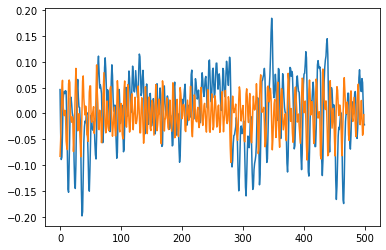

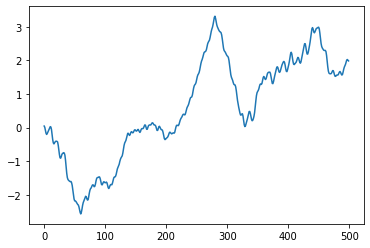

In [10]:
# obtener features de las series de tiempo
train_features = extract_featuresAll(X_train)
val_features = extract_featuresAll(X_val)
test_features = extract_featuresAll(X_test)

print(train_features.shape)
print(val_features.shape)
print(test_features.shape)

plt.plot(X_train[0])
plt.plot(np.diff(X_train, axis=1)[0])
plt.show()
plt.plot(np.cumsum(X_train, axis=1)[0])
plt.show()

np.savez('featured_data.npz',
         X_train=train_features, Y_train=Y_train,
         X_val=val_features, Y_val=Y_val,
         X_test=test_features, Y_test=Y_test)

In [11]:
# extraccion de espectogramas
from scipy import signal

def get_spectrogram(X, fs=1.0, title='', plot=False):
  """
  obtiene el spectograma de los datos de X
  """

  f, t, spectro = signal.spectrogram(X, fs=fs,
                                     nperseg=nperwd,
                                     noverlap=nperwd-nleap)

  # print(f.shape, t.shape, spectro.shape)
  
  if plot:
    # crear meshgrid para plot
    X, Y = np.meshgrid(t, f)

    # configurar plot
    plt.figure( figsize=(15, 4) )
    plt.title(title)
    plt.xlabel('Time (seg)'); plt.ylabel('Frecueny (Hz)')

    # plot
    plt.contourf( X, Y, spectro, levels=256, cmap='magma')
    plt.colorbar()
    plt.show()

  return spectro.T

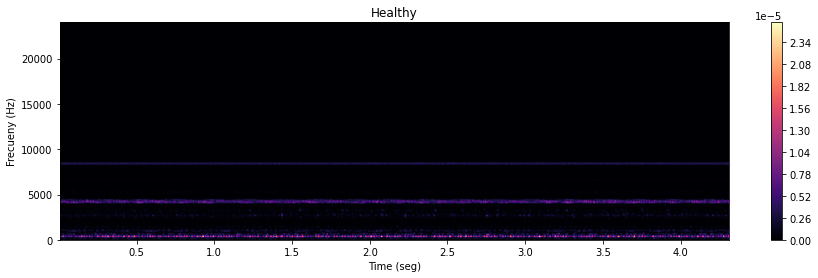

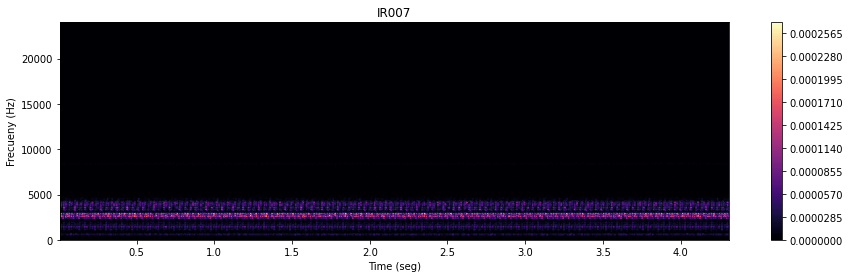

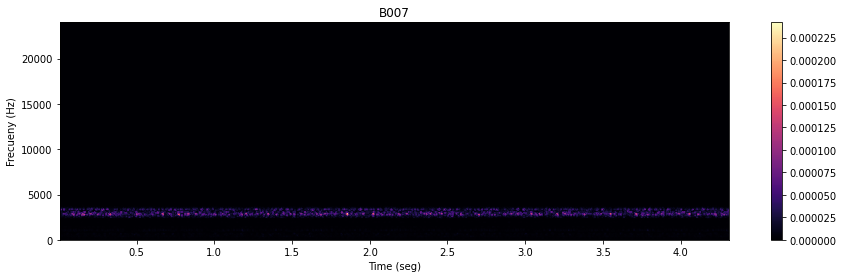

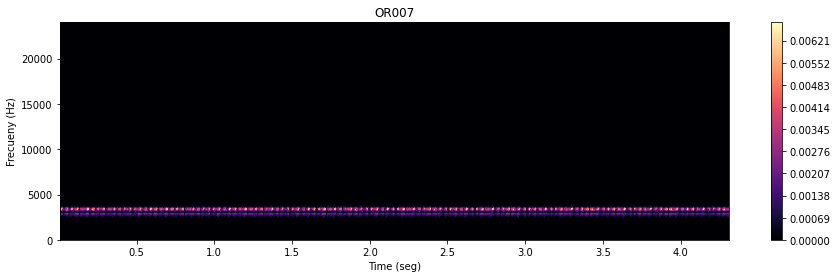

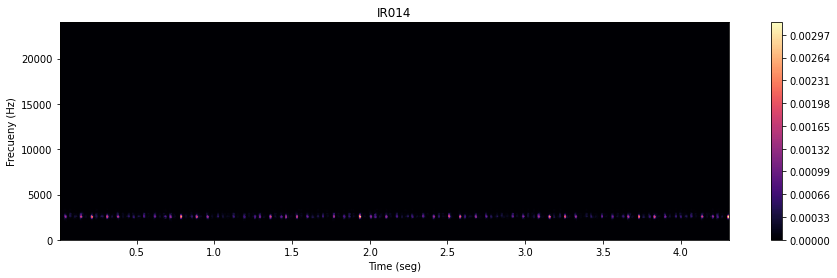

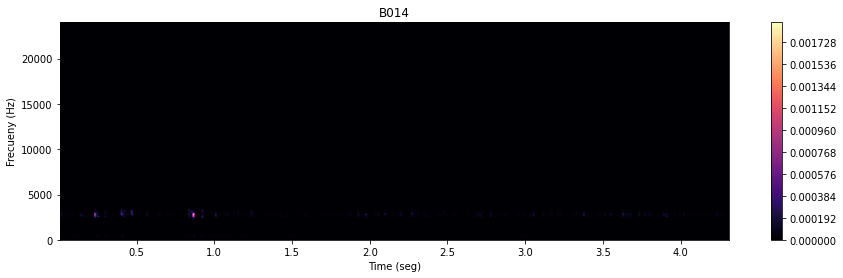

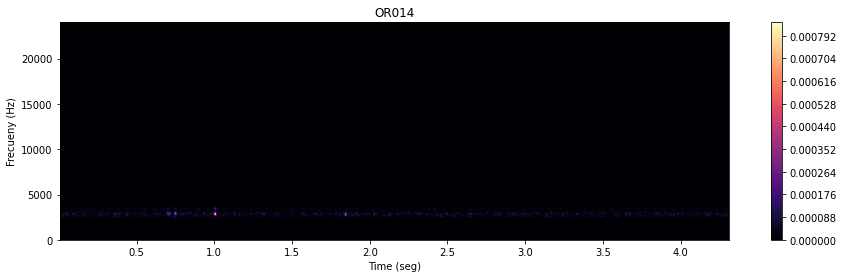

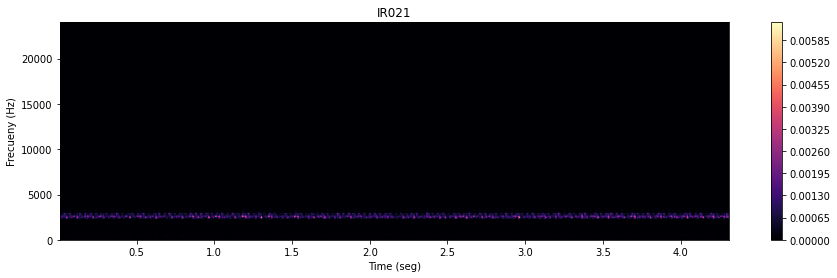

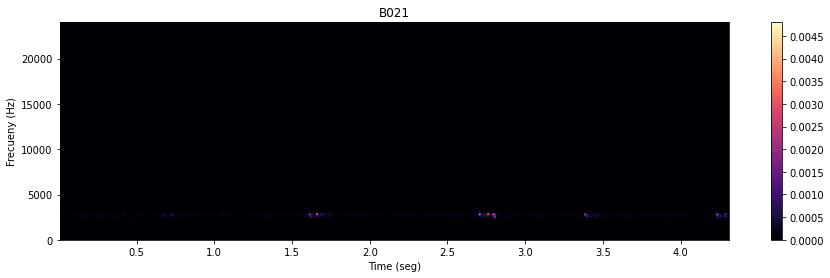

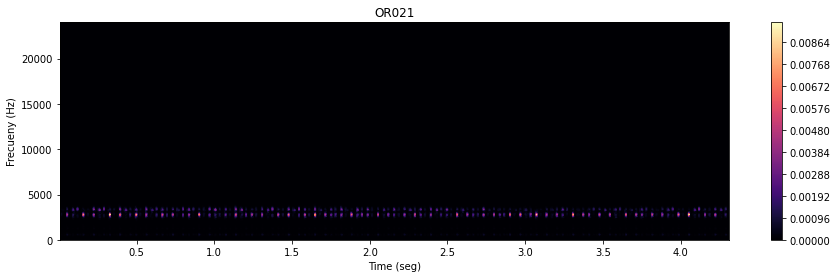

(10350, 251)
(2570, 251)
(1420, 251)


In [12]:
cols = ['Healthy','IR007','B007','OR007','IR014',
        'B014','OR014','IR021','B021','OR021']

train_spectros = []
for col in cols:
  train_spectros.append(get_spectrogram(train_data[col].values, fs=48e3, title=col, plot=True))
train_spectros = np.vstack(train_spectros)

val_spectros = []
for col in cols:
  val_spectros.append(get_spectrogram(val_data[col].values, fs=48e3, title=col))
val_spectros = np.vstack(val_spectros)

test_spectros = []
for col in cols:
  test_spectros.append(get_spectrogram(test_data[col].values, fs=48e3, title=col))
test_spectros = np.vstack(test_spectros)

print(train_spectros.shape)
print(val_spectros.shape)
print(test_spectros.shape)

np.savez('spectros_data.npz',
         X_train=train_spectros, Y_train=Y_train,
         X_val=val_spectros, Y_val=Y_val,
         X_test=test_spectros, Y_test=Y_test)

In [13]:
# modelos

import keras
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler


In [14]:
def plot_confusion_matrix(Y_true, Y_pred, target_names,
                          title='Confusion matrix',
                          cmap=None, normalize=False,
                          figsize=(5,5)):
    
    """
    given the true (Y_true) and the predicted (Y_pred) labels,
    makes the confusion matrix.
    
    :param np.array Y_true:
        the true labels of the data. (no one hot encoding).
    :param np.array Y_pred:
        the predicted labels of the data by the model. (no one hot encoding).
    :param list target_names:
        given classification classes such as [0, 1, 2] the class names,
        for example: ['high', 'medium', 'low'].
    :param str title:
        the text to display at the top of the matrix.
    :param str cmap:
        the gradient of the values displayed from matplotlib.pyplot.cm
        see http://matplotlib.org/examples/color/colormaps_reference.html
        plt.get_cmap('jet') or plt.cm.Blues.
    :param bool normalize:
        if False, plot the raw numbers, if True, plot the proportions.
        
    :reference:
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        
    """
    import itertools
    
    cm = confusion_matrix(Y_true, Y_pred)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                      verticalalignment="center",
                      horizontalalignment="center",
                      color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                      verticalalignment="center",
                      horizontalalignment="center",
                      color="white" if cm[i, j] > thresh else "black")
    
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    

In [17]:
def run(X_train, X_val, X_test, input_features,
        title, lr=0.001, nepochs=100, opt_='Adam'):
  # scaler
  scaler = MinMaxScaler(feature_range=(-1,1))
  scaler.fit(X_train)
  
  labels_num = 10

  callback = keras.callbacks.EarlyStopping(patience=50, verbose=True)

  X_train = scaler.transform(X_train)
  X_val = scaler.transform(X_val)
  X_test = scaler.transform(X_test)

  fig, axs = plt.subplots(2, 1, figsize=(10,10), sharex=True)

  colors = ['b','r','orange','g','purple']
  ACC = []
  for  i in range(5):
    if opt_ == 'Adam':
      opt = keras.optimizers.Adam(learning_rate=lr)
    elif opt_ == 'Adagrad' :
      opt = keras.optimizers.RMSprop(learning_rate=lr)
    else:
      opt = keras.optimizers.Adagrad(learning_rate=lr)

    print('model ', title)
    model = Sequential()
    input_dim = (input_features, )
    model.add( Input( shape=input_dim ) )
    model.add( Dense(units=32, activation='relu') )
    model.add( Dense(units=32, activation='relu') )
    model.add( Dense(units=labels_num, activation='softmax') )
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt, metrics=['accuracy'])

    history = model.fit(X_train,
                        Y_train,
                        batch_size=64,
                        epochs=nepochs,
                        callbacks=[callback],
                        validation_data=(X_val, Y_val),
                        verbose=0)

    # evaluar modelo y graficar curva de loss

    loss, acc = model.evaluate(X_test, Y_test)
    ACC.append(acc)

    axs[0].plot(history.history['loss'], label='train', alpha=0.5, c=colors[i])
    axs[0].plot(history.history['val_loss'], alpha=0.5, ls='--', c=colors[i])
    axs[1].plot(history.history['accuracy'], alpha=0.5, c=colors[i])
    axs[1].plot(history.history['val_accuracy'], label='val', alpha=0.5, ls='--', c=colors[i])
    
  print('Accuracy promedio: {:.2f}'.format(np.mean(ACC)))

  axs[0].set_ylabel('Loss')
  axs[0].set_title(title)
  axs[0].legend()

  axs[1].set_xlabel('epochs'), axs[1].set_ylabel('Accuracy')
  axs[1].legend()
  plt.show()

  pred = model.predict(X_test)
  pred = np.argmax(pred, axis=1)

  plot_confusion_matrix(np.argmax(Y_test, axis=1), pred, target_names=cols)

  return model


model  RAW data model
Epoch 00085: early stopping
45/45 [==============================] - 0s 2ms/step - loss: 0.4788 - accuracy: 0.8711
model  RAW data model
Epoch 00079: early stopping
45/45 [==============================] - 0s 2ms/step - loss: 0.7680 - accuracy: 0.8218
model  RAW data model
Epoch 00080: early stopping
45/45 [==============================] - 0s 2ms/step - loss: 0.4795 - accuracy: 0.8718
model  RAW data model
Epoch 00075: early stopping
45/45 [==============================] - 0s 2ms/step - loss: 0.5404 - accuracy: 0.8542
model  RAW data model
Epoch 00088: early stopping
45/45 [==============================] - 0s 2ms/step - loss: 0.6371 - accuracy: 0.8352
Accuracy promedio: 0.85


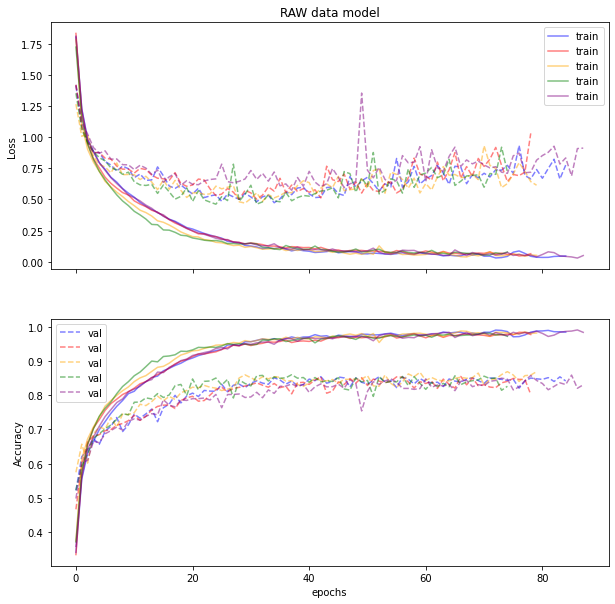

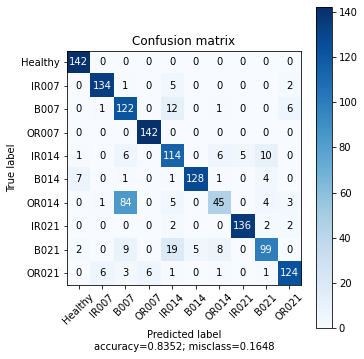

In [18]:
model = run(X_train, X_val, X_test, nperwd, 'RAW data model',
            lr=0.003, nepochs=500)

model  featured data model
Epoch 00229: early stopping
45/45 [==============================] - 0s 2ms/step - loss: 0.2832 - accuracy: 0.8979
model  featured data model
Epoch 00220: early stopping
45/45 [==============================] - 0s 2ms/step - loss: 0.3039 - accuracy: 0.9035
model  featured data model
Epoch 00207: early stopping
45/45 [==============================] - 0s 2ms/step - loss: 0.3677 - accuracy: 0.8803
model  featured data model


KeyboardInterrupt: ignored

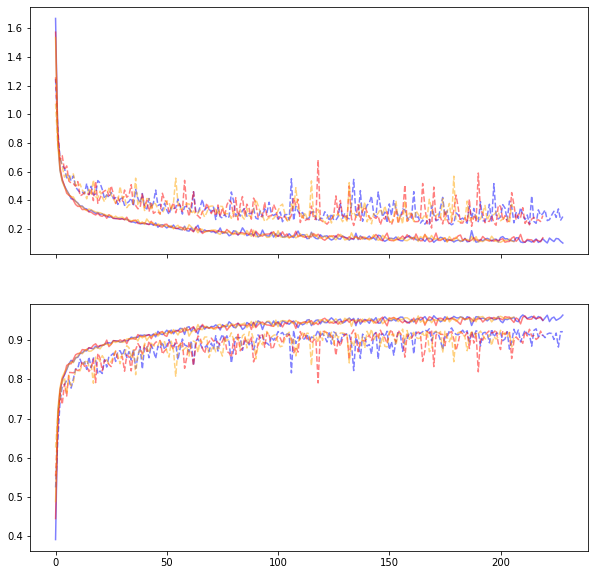

In [19]:
model_f = run(train_features, val_features, test_features, train_features.shape[1], 'featured data model', lr=0.003, nepochs=500)


In [ ]:
model_s = run(train_spectros, val_spectros, test_spectros, train_spectros.shape[1], 'spectred data model', lr=0.003, nepochs=1000)


In [ ]:
# prueba de optimizadores
model = run(X_train, X_val, X_test, nperwd, 'RAW data model',
            lr=0.003, nepochs=500, opt_='RMSprop')

In [ ]:
model = run(X_train, X_val, X_test, nperwd, 'RAW data model',
            lr=0.003, nepochs=500, opt_='Adagrad')

In [ ]:
model_f = run(train_features, val_features, test_features, train_features.shape[1], 'featured data model', lr=0.003, nepochs=500, opt_='RMSprop')


In [ ]:
model_f = run(train_features, val_features, test_features, train_features.shape[1], 'featured data model', lr=0.003, nepochs=500, opt_='Adagrad')


In [ ]:
model_s = run(train_spectros, val_spectros, test_spectros, train_spectros.shape[1], 'spectred data model', lr=0.003, nepochs=1000, opt_='RMSprop')


In [ ]:
model_s = run(train_spectros, val_spectros, test_spectros, train_spectros.shape[1], 'spectred data model', lr=0.003, nepochs=1000, opt_='Adagrad')
